# Cellular properties overview & Single-cell/global correlations

## imports & installations

In [3]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import sys
import scipy
import itertools
import os
import scipy

warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

sys.path.append('/sise/home/shakarch/muscle-formation-diff')
sys.path.append(os.path.abspath('..'))

from TimeSeriesAnalysis.utils.data_load_save import *
# import TimeSeriesAnalysis.consts as consts
import TimeSeriesAnalysis.params as params
from TimeSeriesAnalysis.auc_over_time_diff_prob import *

## data loading - differentiation scores dataframes & other calculated properties

In [4]:
properties_df_s5 =  get_all_properties_df("actin_intensity", 2, 3, scores_vid_num=5)
properties_df_s1 =  get_all_properties_df("actin_intensity", 2, 3, scores_vid_num=1)
properties_df_s3 =  get_all_properties_df("actin_intensity", 1, 5, scores_vid_num=3)
properties_df_s2 =  get_all_properties_df("actin_intensity", 1, 5, scores_vid_num=2)
properties_df_s6 =  get_all_properties_df("actin_intensity", 1, 5, scores_vid_num=6)
properties_df_s8 =  get_all_properties_df("actin_intensity", 1, 5, scores_vid_num=8)

properties_df_s3.head()

,score_motility,score_intensity,coordination,local_density,Spot frame,time,Spot track ID,min,max,mean,sum,x,y,persistence,directionality_cos_alpha,speed,speed_change,Spot position X,Spot position Y
0,0.895845,0.179963,NaN,6.0,82.0,6.833333,1.0,188.0,711.0,379.057617,388155.0,2041.0,2504.0,0.072409,0.641977,2.890145,-0.533617,943.222656,1156.871826
1,0.889756,0.200180,NaN,6.0,83.0,6.916667,1.0,230.0,763.0,392.603516,402026.0,2041.0,2493.0,0.060796,-0.006073,4.653162,1.763017,943.194397,1152.218750
2,0.847672,0.224217,NaN,6.0,84.0,7.000000,1.0,186.0,1121.0,371.957031,380884.0,2041.0,2484.0,0.050120,-0.023499,4.394768,-0.258394,943.091125,1147.825195
3,0.873719,0.288710,NaN,6.0,85.0,7.083333,1.0,106.0,1583.0,375.641602,384657.0,2042.0,2472.0,0.020904,0.059311,5.429358,1.034590,943.413147,1142.405396
4,0.904847,0.308903,NaN,6.0,86.0,7.166667,1.0,182.0,4881.0,586.167969,600236.0,2040.0,2462.0,0.058198,-0.178587,4.794980,-0.634378,942.556824,1137.687500


In [5]:
# re-add spot position columns and recalculate speed

def add_spot_position_columns(properties_df, vid_num):
    prop_cols = ["Spot track ID","Spot frame", "score_motility", "score_intensity","coordination", "local_density", 
                                                  "time", "min", "max", "mean", "sum", "persistence", "directionality_cos_alpha"]
    df_s_cols = ["Spot track ID","Spot frame","Spot position X", "Spot position Y"]
    
    path = fr'/storage/users/assafzar/Muscle_Differentiation_AvinoamLab/data/mastodon/{params.registration_method}'
    s_df, s_track_list = get_tracks(path + f"S{vid_num} all detections.csv", manual_tagged_list=True)
    
    properties_df = pd.merge(left=properties_df[prop_cols], 
                                right=s_df.drop_duplicates(subset=["Spot track ID","Spot frame"])[df_s_cols] ,
                                on=["Spot track ID","Spot frame"], how='left')
    return properties_df
    
properties_df_s6 = add_spot_position_columns(properties_df_s6, 6)
properties_df_s8 = add_spot_position_columns(properties_df_s8, 8)

properties_df_s3 = add_spot_position_columns(properties_df_s3, 3)
properties_df_s2 = add_spot_position_columns(properties_df_s2, 2)

properties_df_s1 = add_spot_position_columns(properties_df_s1, 1)
properties_df_s5 = add_spot_position_columns(properties_df_s5, 5)


def get_new_speed(track_data):
    pd.options.display.float_format = '{:,.9f}'.format 
    x_col = "Spot position X"
    y_col = "Spot position Y"
    track_data["time"] = track_data["Spot frame"] * 5 / 60
    track_data = track_data[["Spot frame", x_col, y_col, "Spot track ID", "time"]]
    track_data = track_data.sort_values("Spot frame")

    track_data['speed_x'] = track_data.groupby(['Spot track ID'])[x_col].transform(lambda x: x.diff()) 
    track_data['speed_y'] = track_data.groupby(['Spot track ID'])[y_col].transform(lambda x: x.diff()) 

    track_data["speed"] = np.sqrt(np.square(track_data["speed_x"]) + np.square(track_data["speed_y"]))
    track_data['speed_change'] = track_data.groupby(['Spot track ID'])['speed'].diff()#.transform(lambda x: x.pct_change()) 
    
    return track_data["speed"], track_data['speed_change']

properties_df_s6["speed"], properties_df_s6['speed_change'] = get_new_speed(properties_df_s6)
properties_df_s3["speed"], properties_df_s3['speed_change'] = get_new_speed(properties_df_s3)
properties_df_s2["speed"], properties_df_s2['speed_change'] = get_new_speed(properties_df_s2)
properties_df_s8["speed"], properties_df_s8['speed_change'] = get_new_speed(properties_df_s8)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 893713 entries, 2 to 893714
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       893713 non-null  int32  
 1   Spot position X  893713 non-null  float32
 2   Spot position Y  893713 non-null  float32
 3   manual           893713 non-null  int8   
 4   Spot frame       893713 non-null  int16  
 5   Spot track ID    893713 non-null  int16  
 6   target           893713 non-null  int8   
dtypes: float32(2), int16(2), int32(1), int8(2)
memory usage: 22.2 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1647210 entries, 2 to 1647211
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Unnamed: 0       1647210 non-null  int32  
 1   Spot position X  1647210 non-null  float32
 2   Spot position Y  1647210 non-null  float32
 3   manual           1647210 non-null  

## Cellular properties overview

the displayed data: 

S3 video, (Erki, 211212_CD7_ERK_P38), S2 video, (DMSO, 211212_CD7_ERK_P38), S6 video, (Erki + P38, 211212_CD7_ERK_P38), S8 video, (P38, 211212_CD7_ERK_P38)  
as the test set data. the scores are based on a model that was trained on videos s1 (DMSO,211006_CD7_DMSO_ERKi) & s5 (ERKi, 211006_CD7_DMSO_ERKi).
The followiing displayed trackes are *all* the manually-tracked cells.

In [2]:
def plot_property_over_time(properties_df_lst, features_list, time=(0,25)):
    sns.set_style("darkgrid")
    dfs = list(map(lambda x: x[0], properties_df_lst))
    labels = list(map(lambda x: x[1], properties_df_lst))
    colors = list(map(lambda x: x[2], properties_df_lst))

    tot = len(features_list)
    cols = 2
    rows = tot // cols
    # EDIT for correct number of rows:
    # If one additional row is necessary -> add one:
    if tot % cols != 0:
        rows += 1
    position = range(1, tot + 1)
    fig = plt.figure(1, figsize=(14,14))

    for k in range(tot):
        f = features_list[k]
        ax = fig.add_subplot(rows, cols, position[k])
        for df, label, color in zip(dfs, labels, colors):   

            
            df = df[(df["time"]>= time[0]) & (df["time"]< time[1])]
            df = df.sort_values("time")
            mean = df.groupby("time")[f].mean()
            std = df.groupby("time")[f].std()
            ax.plot(mean, color=color, label=label)
            # plt.fill_between(df["time"].unique(), mean - std, mean + std, alpha=0.4, color=color, label=label)
            
            ax.axvspan(6, 13, alpha=0.3, color='lightgray')
            ax.axvline(6, color='gray', linestyle='dashed')
            ax.axvline(13, color='gray', linestyle='dashed')
            
            ax.set_ylabel(f"{f}")
            ax.set_xlabel(f"time")
            ax.set_title(f'{f} over time')
            ax.legend()

time = (0,25)  
features_list = ["speed", "local_density", "persistence", "mean",  "speed_change"]

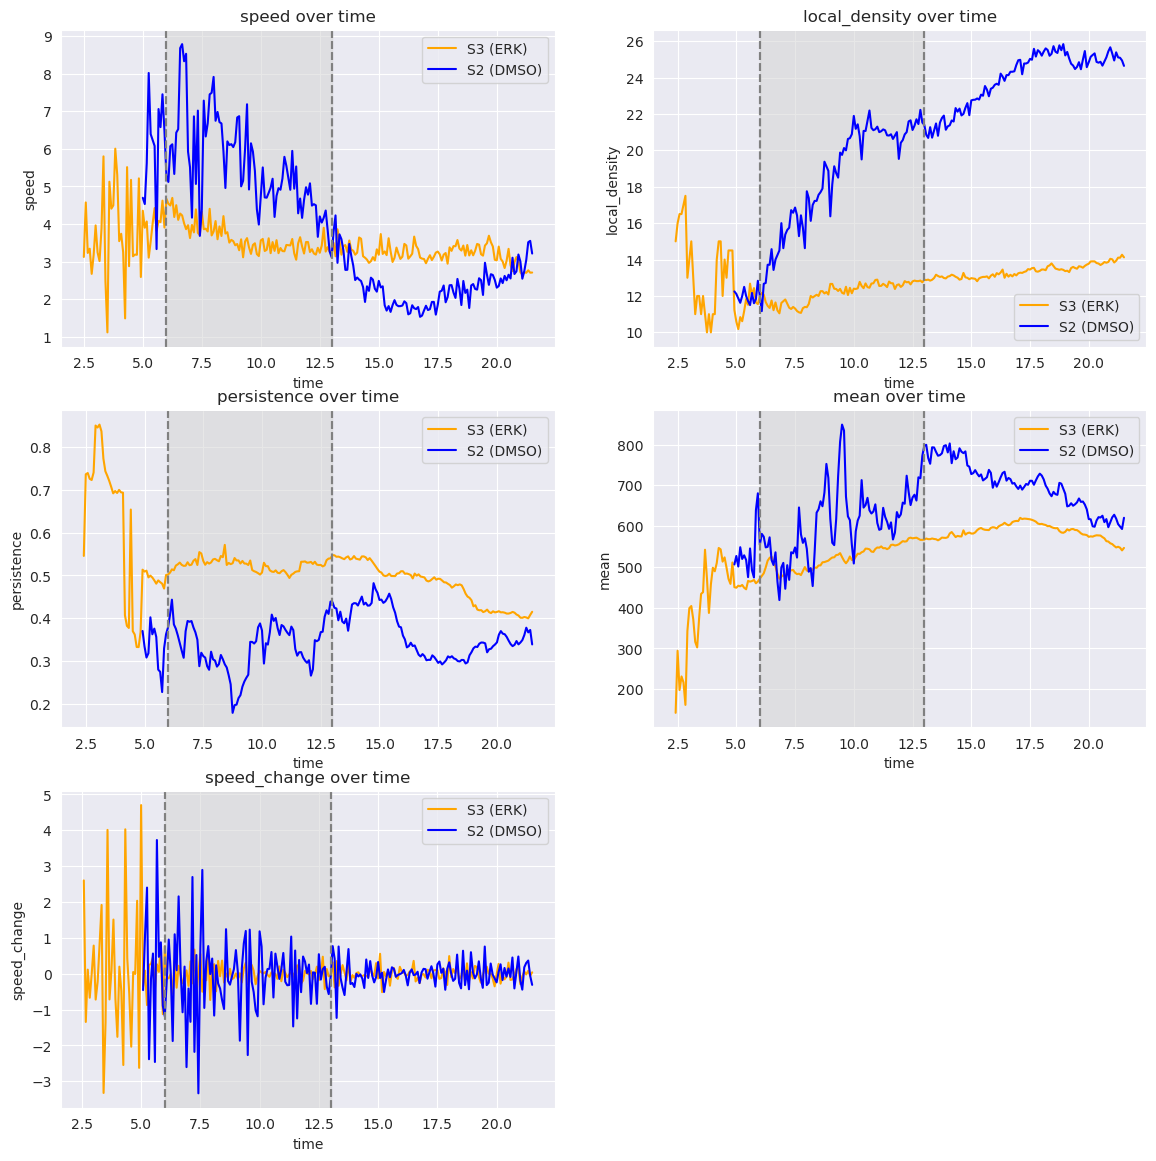

In [109]:
data = [(properties_df_s3, "S3 (ERK)","orange") ,(properties_df_s2, "S2 (DMSO)", "blue")]
plot_property_over_time(data, features_list, time=time)

the displayed data: 

S1 video, (DMSO,211006_CD7_DMSO_ERKi), S5 video, (Erki,211006_CD7_DMSO_ERKi)
as the test set data. the scores are based on a model that was trained on videos S3 (Erki, 211212_CD7_ERK_P38) & S2 (DMSO, 211212_CD7_ERK_P38).
The followiing displayed trackes are *all* the manually-tracked cells.

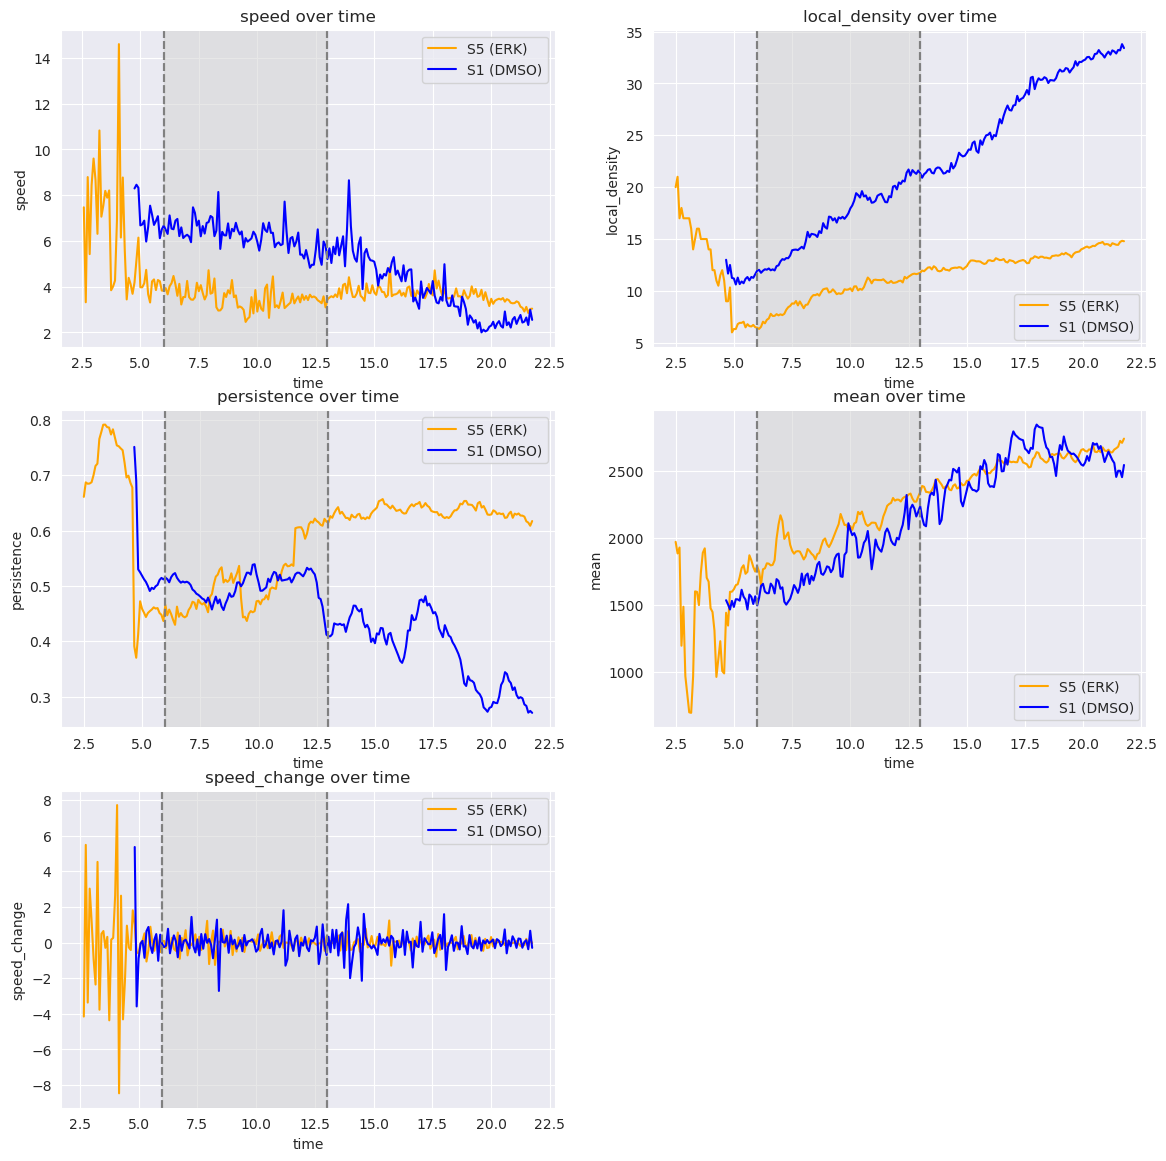

In [110]:
data = [(properties_df_s5, "S5 (ERK)","orange") ,(properties_df_s1, "S1 (DMSO)", "blue")]
plot_property_over_time(data, features_list, time=time)

## Correlations- Single cell Level

### display a single cell level correlations in a distribution

In [6]:
def get_corr_values(data, time, x_property, y_property, rolling_window, corr_metric):
    data = data[(data["time"]>=time[0]) & (data["time"]<=time[1])]
    corr = np.array(data.astype('float64').groupby('Spot track ID').apply(lambda df: df[x_property].rolling(rolling_window).mean().corr(df[y_property].rolling(rolling_window).mean(),method=corr_metric)))
    return corr

def plot_single_cell_corr_dist(data, comp_features_list, vid_name, rolling_window=1, time=(0,25), color="orange", corr_metric="pearson"):
    sns.set_style("darkgrid")
    tot = len(comp_features_list)
    cols = 3
    rows = tot // cols
    # EDIT for correct number of rows:
    # If one additional row is necessary -> add one:
    if tot % cols != 0:
        rows += 1
    position = range(1, tot + 1)
    figsize = (8 if tot < 2 else tot * 2, 4 if tot < 2 else tot)
    fig = plt.figure(1, figsize=figsize)
    
    
    for k in range(tot):
        x_property, y_property = comp_features_list[k]
        
        corr = get_corr_values(data, time, x_property, y_property, rolling_window, corr_metric)
        corr = corr[~np.isnan(corr)]
        ax = fig.add_subplot(rows, cols, position[k])
        
        from scipy import stats
        ax.hist(corr, color=color, density=False, alpha=0.5) # density=True
        kde = stats.gaussian_kde(corr)
        ax.plot(np.linspace(-1, 1, 1000), kde(np.linspace(-1, 1, 1000)), color=color)
        
        ax.axvline(np.nanmedian(corr), color='r', linestyle='dashed')
        ax.text(np.nanmedian(corr)*1.15, 0.1, 'Median: {:.2f}'.format(np.nanmedian(corr)))
    
        ax.axvline(np.nanmean(corr), color='g', linestyle='dashed')
        ax.text(np.nanmean(corr)*1.15, 6.5, 'Mean: {:.2f}'.format(np.nanmean(corr)))
    
        ax.set_xlim((-1,1))
        ax.set_title(f" between \n{x_property} & {y_property}")
    
    plt.suptitle(f"distribution of single cell's correlation; vid {vid_name} rolling={rolling_window}")
    plt.tight_layout()
    plt.show()

### correlations of S3

the displayed data: 

S3 video, (Erki, 211212_CD7_ERK_P38)- as the test set data. the scores are based on a model that was trained on videos s1 (DMSO,211006_CD7_DMSO_ERKi) & s5 (ERKi, 211006_CD7_DMSO_ERKi).
The followiing displayed trackes are *all* the manually-tracked cells from video S3.

#### correlations with cellular properties

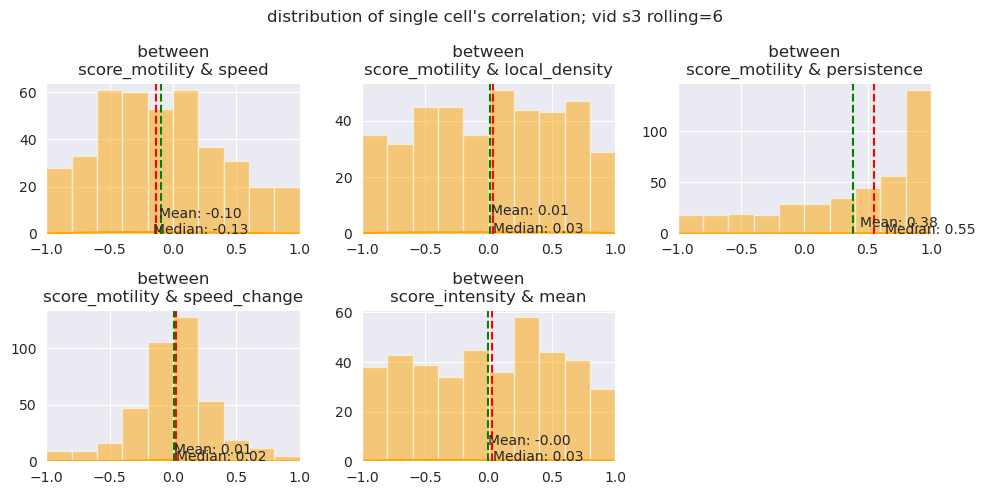

In [20]:
score_motility_features_list = [("score_motility", "speed"), ("score_motility", "local_density"), ("score_motility", "persistence"), ("score_motility", "speed_change"), ("score_intensity", "mean")] 
plot_single_cell_corr_dist(properties_df_s3, score_motility_features_list, "s3", rolling_window=6, time=(6,13))

#### correlations with time

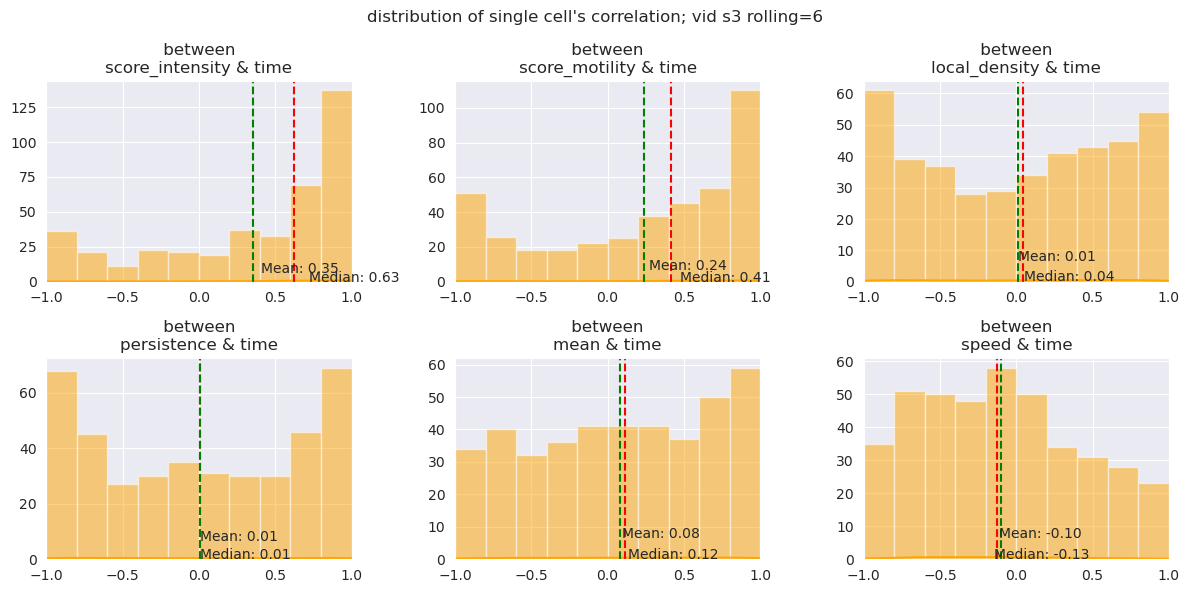

In [23]:
time_features_list = [("score_intensity", "time"),("score_motility", "time"), ("local_density", "time"), ("persistence", "time"),("mean", "time"), ("speed", "time") ] #("speed_change", "time")
plot_single_cell_corr_dist(properties_df_s3, time_features_list, "s3", rolling_window=6, time=(6,13), corr_metric="spearman")

### correlations of S2

the displayed data: 

S2 video, (DMSO, 211212_CD7_ERK_P38)- as the test set data. the scores are based on a model that was trained on videos s1 (DMSO,211006_CD7_DMSO_ERKi) & s5 (ERKi, 211006_CD7_DMSO_ERKi).
The followiing displayed trackes are *all* the manually-tracked cells from video S2.

#### correlations with cellular properties

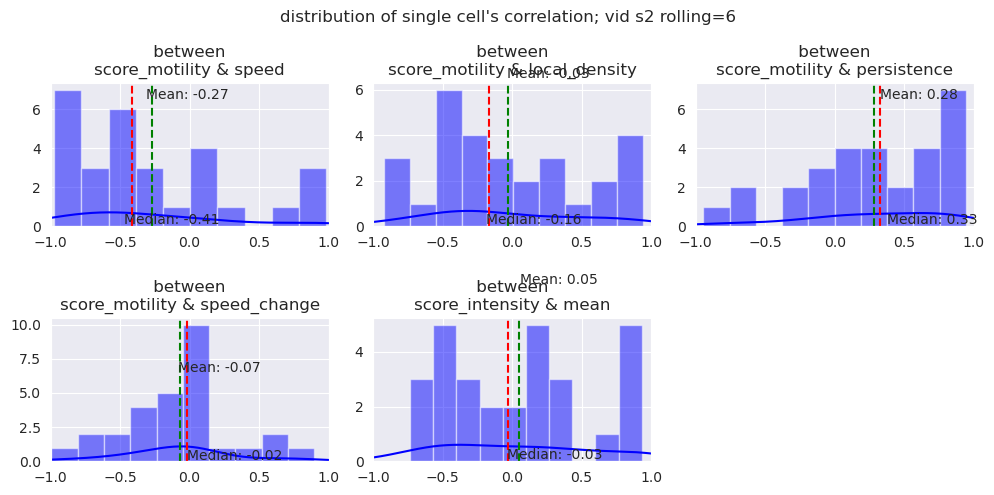

In [83]:
plot_single_cell_corr_dist(properties_df_s2, score_motility_features_list, "s2", rolling_window=6, time=(6,13), color="blue")

#### correlations with time

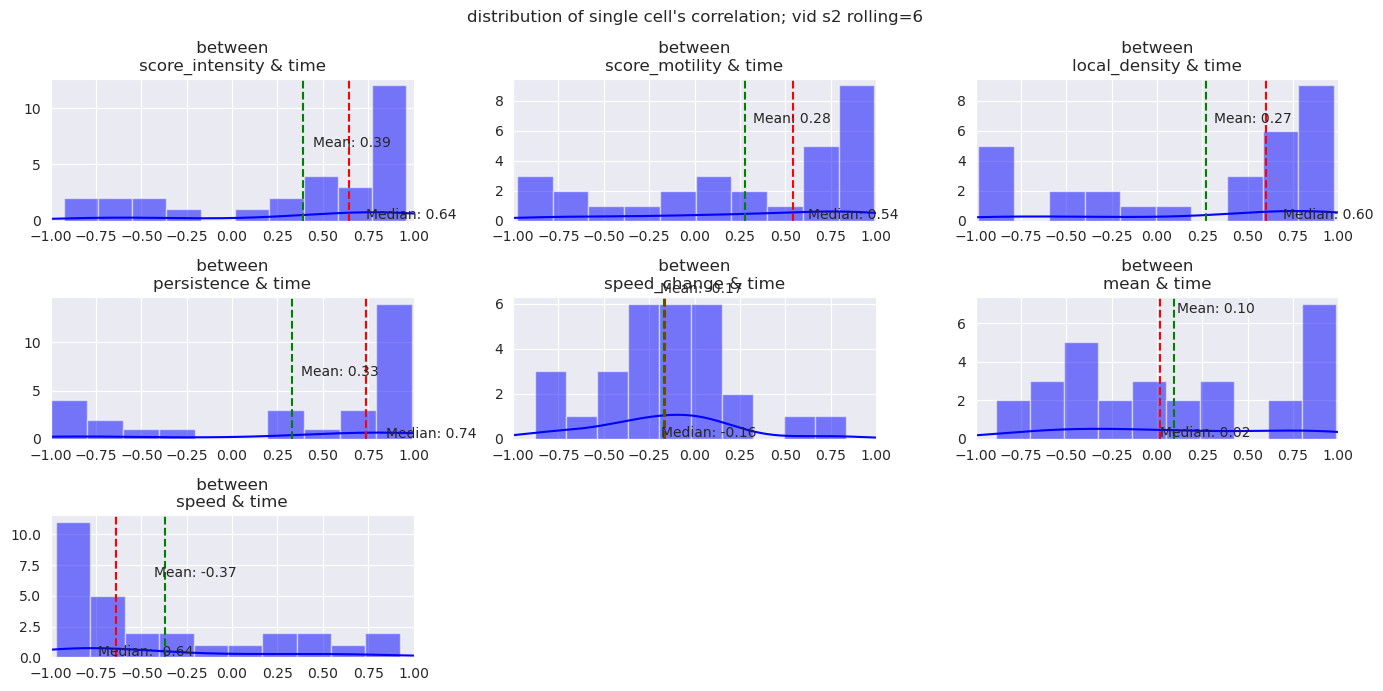

In [84]:
plot_single_cell_corr_dist(properties_df_s2, time_features_list, "s2", rolling_window=6, time=(6,13), color="blue")

### correlations of S6

the displayed data: 

S6 video, (DMSO, 211212_CD7_ERK_P38)- as the test set data. the scores are based on a model that was trained on videos s1 (DMSO,211006_CD7_DMSO_ERKi) & s5 (ERKi, 211006_CD7_DMSO_ERKi).
The followiing displayed trackes are *all* the manually-tracked cells from video S6.

#### correlations with cellular properties

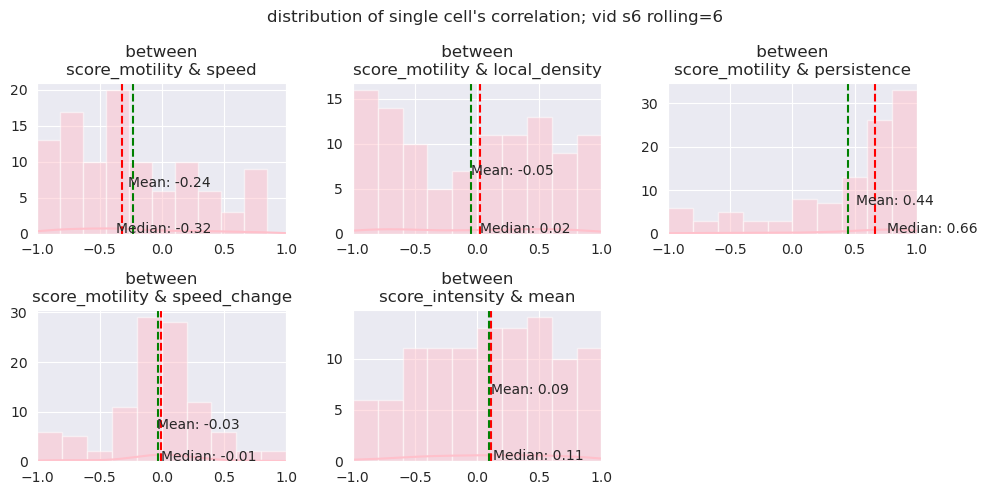

In [86]:
plot_single_cell_corr_dist(properties_df_s6, score_motility_features_list, "s6", rolling_window=6, time=(6,13), color="pink")

#### correlations with time

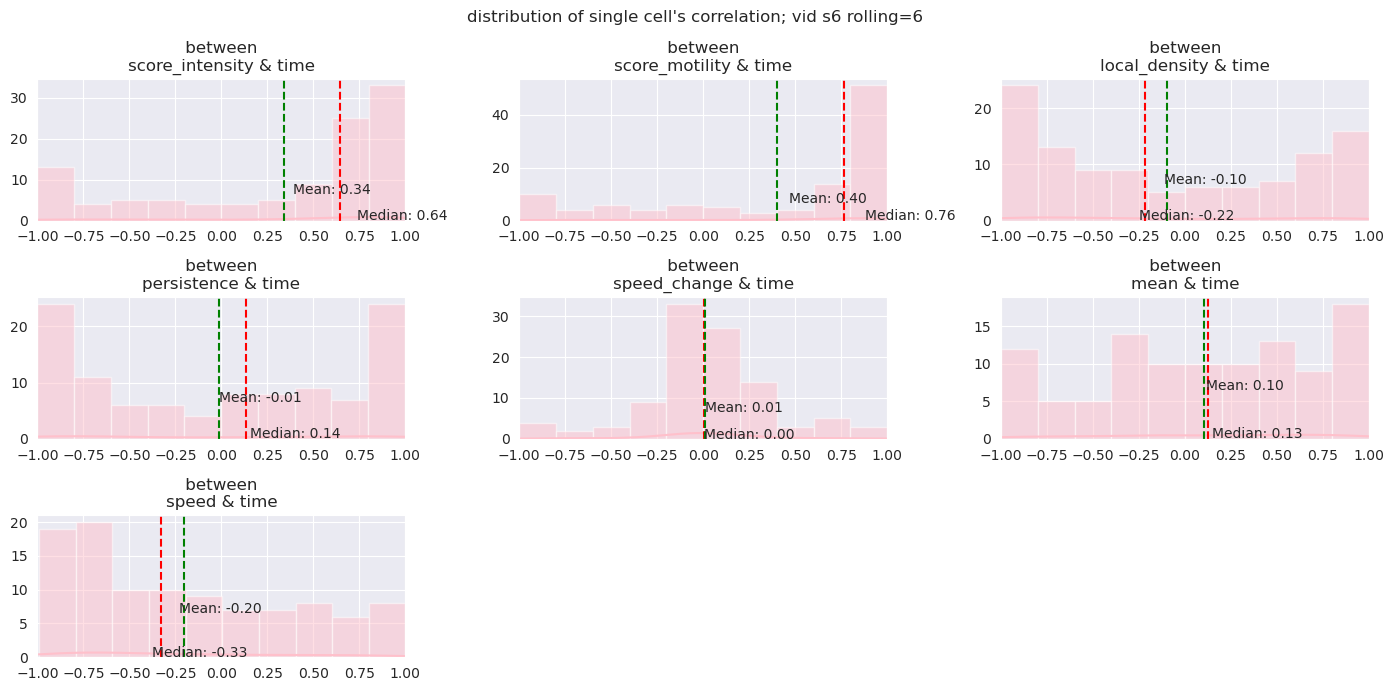

In [85]:
plot_single_cell_corr_dist(properties_df_s6, time_features_list, "s6", rolling_window=6, time=(6,13), color="pink")

### correlations of S8

the displayed data: 

S8 video, (DMSO, 211212_CD7_ERK_P38)- as the test set data. the scores are based on a model that was trained on videos s1 (DMSO,211006_CD7_DMSO_ERKi) & s5 (ERKi, 211006_CD7_DMSO_ERKi).
The followiing displayed trackes are *all* the manually-tracked cells from video S8.

#### correlations with cellular properties

In [ ]:
plot_single_cell_corr_dist(properties_df_s8, score_motility_features_list, "s8", rolling_window=6, time=(6,13), color="green")

#### correlations with time

In [ ]:
plot_single_cell_corr_dist(properties_df_s8, time_features_list, "s8", rolling_window=6, time=(6,13), color="green")

### correlations of S5

the displayed data: 

S5 video, (DMSO,211006_CD7_DMSO_ERKi)- as the test set data. the scores are based on a model that was trained on videos s2 (DMSO, 211212_CD7_ERK_P38) & s3 (DMSO, 211212_CD7_ERK_P38).
The followiing displayed trackes are *all* the manually-tracked cells from video S5.

#### correlations with cellular properties

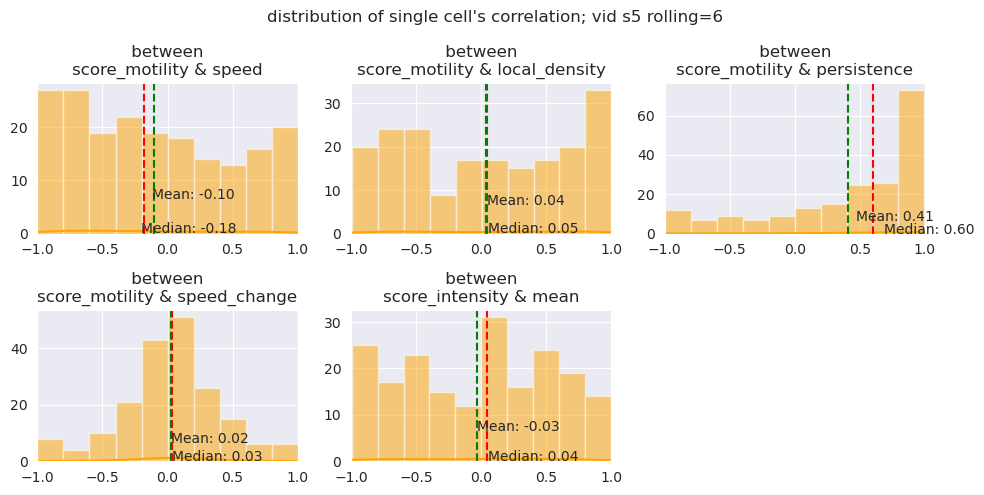

In [113]:
plot_single_cell_corr_dist(properties_df_s5, score_motility_features_list, "s5", rolling_window=6, time=(6,13), color="orange")

#### correlations with time

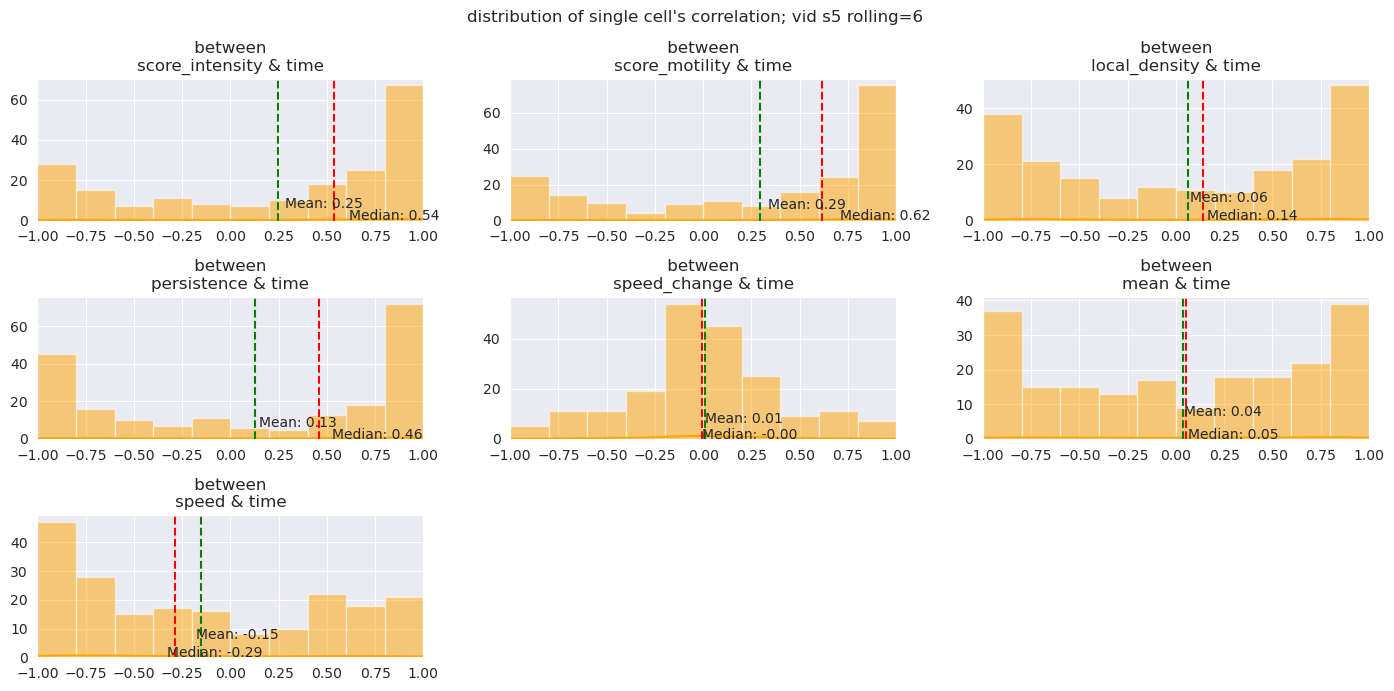

In [114]:
plot_single_cell_corr_dist(properties_df_s5, time_features_list, "s5", rolling_window=6, time=(6,13), color="orange")

### correlations of S1

the displayed data: 

S1 video, (DMSO,211006_CD7_DMSO_ERKi)- as the test set data. the scores are based on a model that was trained on videos s2 (DMSO, 211212_CD7_ERK_P38) & s3 (DMSO, 211212_CD7_ERK_P38).
The followiing displayed trackes are *all* the manually-tracked cells from video S1.

#### correlations with cellular properties

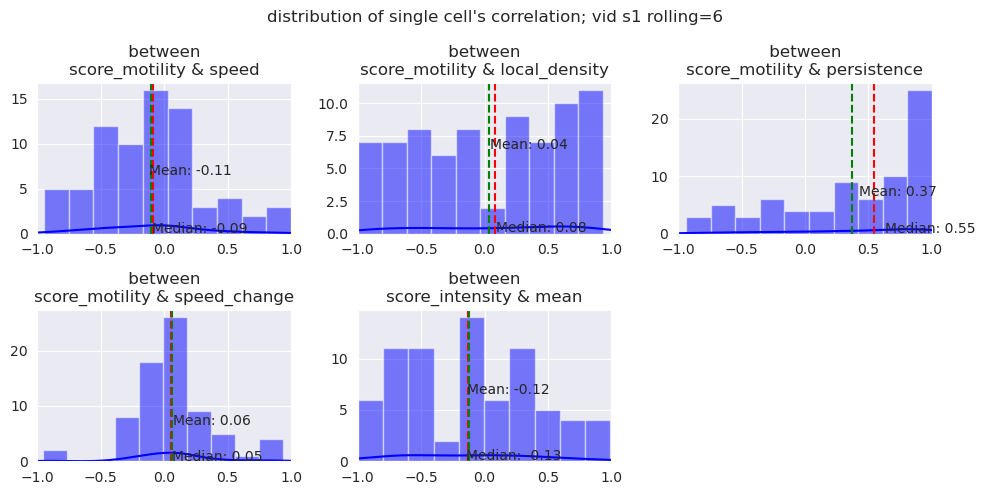

In [111]:
plot_single_cell_corr_dist(properties_df_s1, score_motility_features_list, "s1", rolling_window=6, time=(6,13), color="blue")

#### correlations with time

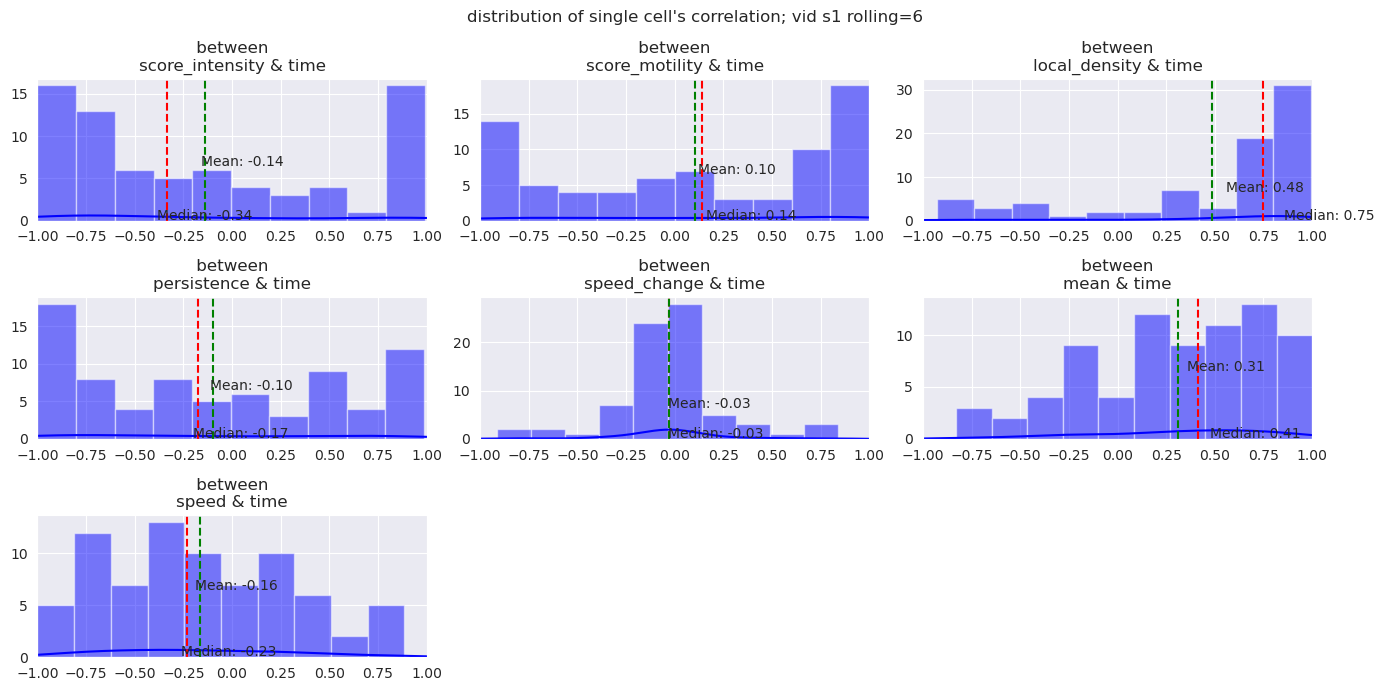

In [112]:
plot_single_cell_corr_dist(properties_df_s1, time_features_list, "s1", rolling_window=6, time=(6,13), color="blue")

### predictors level of consent

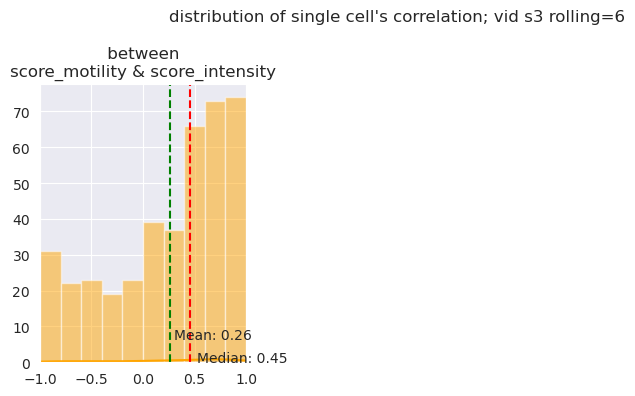

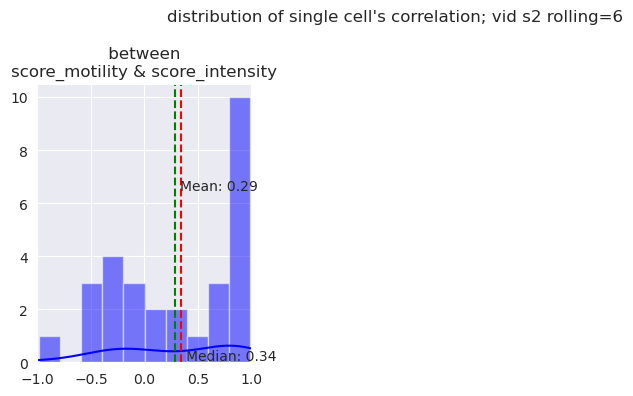

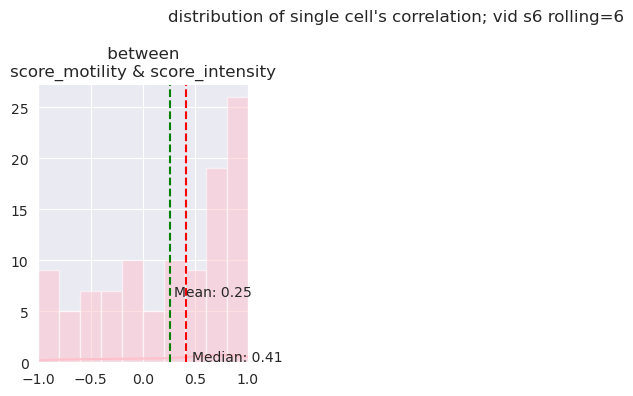

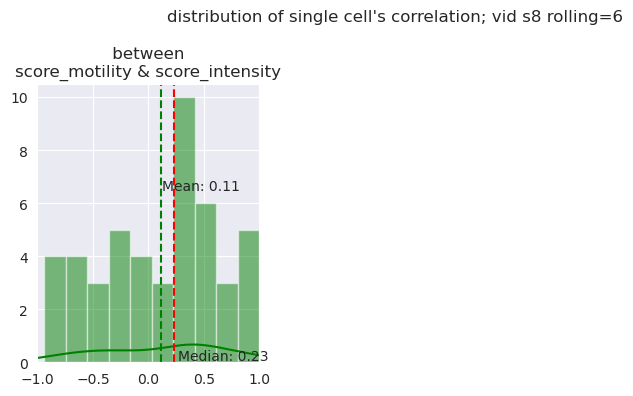

In [22]:
score_motility_features_list = [("score_motility", "score_intensity")] 

plot_single_cell_corr_dist(properties_df_s3, score_motility_features_list, "s3", rolling_window=6, time=(6,13), color="orange", corr_metric="pearson")
plot_single_cell_corr_dist(properties_df_s2, score_motility_features_list, "s2", rolling_window=6, time=(6,13), color="blue", corr_metric="pearson")
plot_single_cell_corr_dist(properties_df_s6, score_motility_features_list, "s6", rolling_window=6, time=(6,13), color="pink", corr_metric="pearson")
plot_single_cell_corr_dist(properties_df_s8, score_motility_features_list, "s8", rolling_window=6, time=(6,13), color="green", corr_metric="pearson")

# plot_single_cell_corr_dist(properties_df_s1, score_motility_features_list, "s1", rolling_window=6, time=(6,13), color="orange", corr_metric="spearman")
# plot_single_cell_corr_dist(properties_df_s5, score_motility_features_list, "s5", rolling_window=6, time=(6,13), color="blue", corr_metric="spearman")


### use the differentiastion score & time correlation to clean noisy cells

In this section, I will use a correlation threshold to filter out cell trajectories with a low differentiation signal.

Objectives:
1. get a high signal cell trajectiries to explore correlations with cell properties on.
2. get the degree of consent between the models, regarding a cell trajectory's differentiation score.

In [11]:
CORR_THRESHOLD = 0.6

In [12]:
def get_cells_by_correlation_threshold(data, threshold, x_property, y_property, vid_name, rolling_window=1, time=(0,25), corr_metric="spearman"):
    data = data.copy()
    data = data[(data["time"]>=time[0]) & (data["time"]<=time[1])]
    data[x_property] = data[x_property].rolling(rolling_window).mean()
    data[y_property] = data[y_property].rolling(rolling_window).mean()
    corr = data.astype('float64').groupby('Spot track ID')[[x_property, y_property]].corr(method=corr_metric).iloc[0::2][[y_property]]
    cell_ids_above_thresh = corr[corr[y_property] > threshold][y_property].reset_index()['Spot track ID']
    return data[data["Spot track ID"].isin(cell_ids_above_thresh)]

In [13]:
high_signal_df_mot = get_cells_by_correlation_threshold(properties_df_s3, CORR_THRESHOLD, "score_motility", "time", "s3", rolling_window=6, time=(6,13))
high_signal_df_act_int = get_cells_by_correlation_threshold(properties_df_s3, CORR_THRESHOLD, "score_intensity", "time", "s3", rolling_window=6, time=(6,13))

In [14]:
print("# of cells trajectories before & after the filtering- motility model")
print("before filtering: ", properties_df_s3['Spot track ID'].nunique())
print("after filtering: ", high_signal_df_mot['Spot track ID'].nunique())

# of cells trajectories before & after the filtering- motility model
before filtering:  556
after filtering:  155


In [15]:
print("# of cells trajectories before & after the filtering- actin intensity model")
print("before filtering: ", properties_df_s3['Spot track ID'].nunique())
print("after filtering: ", high_signal_df_act_int['Spot track ID'].nunique())

# of cells trajectories before & after the filtering- actin intensity model
before filtering:  556
after filtering:  204


In [16]:
# filtered_tracks_mot_int = pd.merge(high_signal_df_mot, high_signal_df_act_int, how='inner', on=['Spot track ID'])
filtered_tracks_mot_int = high_signal_df_mot[high_signal_df_mot["Spot track ID"].isin(high_signal_df_act_int["Spot track ID"].unique())]

print("# of cells trajectories after the filtering- actin intensity AND motility models")
print("after filtering: ", filtered_tracks_mot_int['Spot track ID'].nunique())

# of cells trajectories after the filtering- actin intensity AND motility models
after filtering:  98


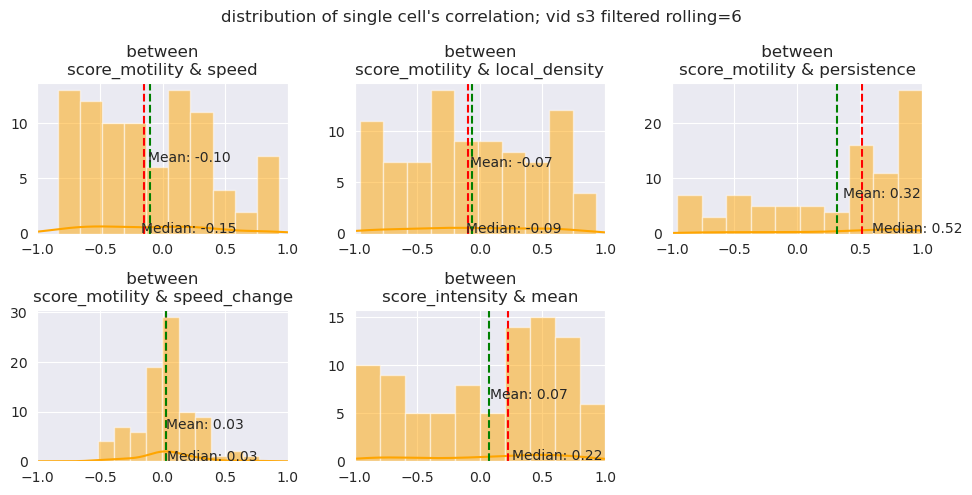

In [21]:
plot_single_cell_corr_dist(filtered_tracks_mot_int, score_motility_features_list, "s3 filtered", rolling_window=6, time=(6,13))

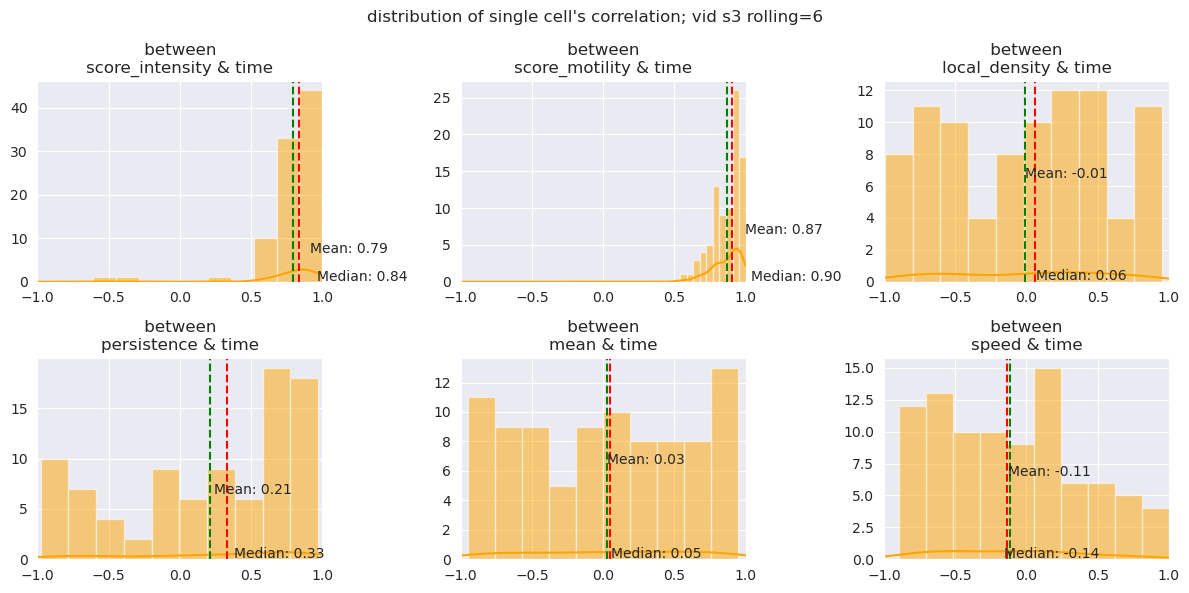

In [18]:
plot_single_cell_corr_dist(filtered_tracks_mot_int, time_features_list, "s3", rolling_window=6, time=(6,13))

In [36]:
filtered_tracks_mot_int

,Spot track ID,Spot frame,score_motility,score_intensity,coordination,local_density,time,min,max,mean,sum,persistence,directionality_cos_alpha,Spot position X,Spot position Y
247,196.000000000,103.000000000,0.342693307,0.166815938,NaN,12.000000000,12.125000000,259.000000000,"1,286.000000000",572.176757812,"585,909.000000000",0.155601174,-0.542249747,714.678894043,684.027954102
248,196.000000000,104.000000000,0.310146792,0.162606132,NaN,11.000000000,11.458333333,152.000000000,"1,135.000000000",548.313476562,"561,473.000000000",0.134923905,-0.851398867,710.936340332,681.722290039
249,196.000000000,105.000000000,0.280938853,0.368701399,NaN,12.000000000,10.791666667,253.000000000,"1,076.000000000",536.128906250,"548,996.000000000",0.110719621,-0.857037732,707.831298828,679.855529785
250,196.000000000,106.000000000,0.267537761,0.365159892,NaN,13.000000000,10.125000000,122.000000000,"1,157.000000000",504.193359375,"516,294.000000000",0.063708946,-0.965635991,705.300292969,679.174316406
251,196.000000000,107.000000000,0.259383947,0.305487021,NaN,12.000000000,9.458333333,224.000000000,910.000000000,447.915039062,"458,665.000000000",0.034394875,-0.491869057,703.660217285,676.271179199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68657,"29,378.000000000",152.000000000,0.831132397,0.987429433,NaN,10.000000000,12.458333333,233.000000000,"1,118.000000000",428.916015625,"439,210.000000000",0.546797156,-0.917049979,226.983230591,355.755828857
68658,"29,378.000000000",153.000000000,0.785446609,0.967540480,NaN,9.000000000,12.541666667,234.000000000,785.000000000,431.833007812,"442,197.000000000",0.422856748,-0.723351193,221.281982422,361.197998047
68659,"29,378.000000000",154.000000000,0.726093806,0.930402668,NaN,9.000000000,12.625000000,259.000000000,704.000000000,437.924804688,"448,435.000000000",0.331800699,-0.693378539,214.835479736,367.897338867
68660,"29,378.000000000",155.000000000,0.674594678,0.931525811,NaN,8.000000000,12.708333333,261.000000000,635.000000000,404.981445312,"414,701.000000000",0.273538262,-0.958508095,210.677917480,369.133819580


# correlations- global

In [117]:
time = (6,13)
comp_features_list = [("score_motility", "speed"), ("score_motility", "local_density"), ("score_motility", "speed_change"), ("score_motility", "persistence"), ("score_intensity", "mean")]
corr_s3 = pd.DataFrame()
corr_s6 = pd.DataFrame()
for x_property, y_property in comp_features_list:
    corr_s3[f"{x_property} over {y_property}"] = get_corr_values(properties_df_s3[["Spot frame", "time", "Spot track ID", x_property, y_property ]], time, x_property, y_property, rolling_window=6)
    
    corr_s6[f"{x_property} over {y_property}"] = get_corr_values(properties_df_s6[["Spot frame", "time", "Spot track ID", x_property, y_property ]], time, x_property, y_property, rolling_window=6)

corr_s3["name"]= "S3 (ERK)"
corr_s6["name"] = "S6 (ERK + P38)"

df = pd.concat([corr_s3, corr_s6])
df_long = df.melt(id_vars=['name'])

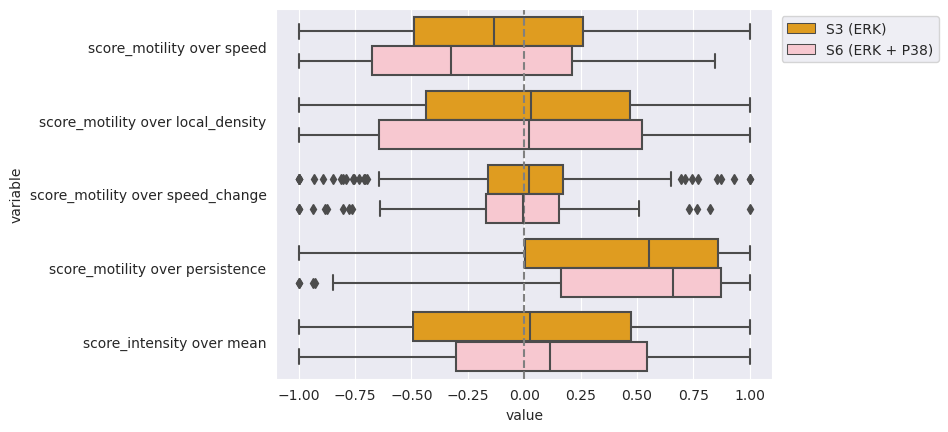

In [118]:
sns.boxplot(data=df_long, orient="h", x="value", y="variable", hue="name", palette={"S3 (ERK)": "orange", "S6 (ERK + P38)": "pink"})
plt.axvline(0, color='gray', linestyle='dashed')
plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1.0))
plt.show()

## Explainability

In [5]:
import shap
import joblib

2022-11-08 10:47:01.393314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-08 10:47:01.393385: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
def get_cols_list(data):
    cols = list(x_test.columns)
    cols = [re.sub('[^A-Za-z0-9 _]+', '', col) for col in cols]
    cols = [col.replace("Spot position X m", "Spot position X") for col in cols]
    cols = [col.replace("Spot position Y m", "Spot position Y") for col in cols]
    cols.remove("Spot track ID")
    # if "Spot track ID" not in cols:
        # cols.extend(["Spot track ID"])
    # if "Spot frame" not in cols:
        # cols.extend(["Spot frame"])
    return cols

def rename_columns(data):
    data = data.rename(columns=lambda x: re.sub('[^A-Za-z0-9 _]+', '', x))
    # data = data.rename(columns={"Spot position X m": "Spot position X", "Spot position Y m": "Spot position Y",})
    data = data.rename(lambda x: x.replace("Spot position X m", "Spot position X") , axis=1)
    data = data.rename(lambda x: x.replace("Spot position Y m", "Spot position Y") , axis=1)
    return data.loc[:, ~data.columns.duplicated()] # remoe duplicates

In [7]:
path_mot = consts.storage_path + f"30-07-2022-motility local dens-False, s1, s5 train/track len 30, impute_func-{params.impute_methodology}_{params.impute_func} reg {params.registration_method}"
clf_motility = joblib.load(path_mot + "/clf.joblib")
x_test = pd.read_csv(clf_motility + "/" + "X_test", encoding="cp1252")
x_test

NameError: name 'consts' is not defined

In [ ]:
clf_motility = joblib.load(model_path_motility + "/clf.joblib")
x_test = pd.read_csv(model_path_motility + "/" + "X_test", encoding="cp1252")
cols_mot = get_cols_list(x_test)
del x_test

model_path_int = fr"C:\Users\Amit\PycharmProjects\muscle-formation-diff\TimeSeriesAnalysis\30-07-2022-actin_intensity local dens-False, s1, s5 train win size 16\track len 30, impute_func-{IMPUTE_METHODOLOGY}_{IMPUTE_FUNC} reg {reg_method}"
clf_act_intencity = joblib.load(model_path_int + "/clf.joblib")